In [1]:
import os
import sys
sys.path.append( os.path.abspath("../../workspace/python-work/python 3/cs230_deeplearning_implement/ec_code/")  )
from class1.week4.assignment4.dnn_app_utils_v2 import *
from class1.week4.assignment4.testCases_v2 import *
from class1.week4.assignment4.dnn_utils_v2 import  *

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)
#搭建多层神经网络以及应用

In [2]:
def initialize_parameters_deep(layers_dims):
    np.random.seed(2)
    L=len(layers_dims)
    parameters={}
    for l in range(1,L):
        parameters["W"+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])/np.sqrt(layers_dims[l-1])
        # parameters["W"+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*0.01 
        parameters["b"+str(l)]=np.zeros((layers_dims[l],1))
        assert ( parameters["W"+str(l)].shape==(layers_dims[l],layers_dims[l-1]) )
        assert ( parameters["b"+str(l)].shape==(layers_dims[l],1) )
    return parameters


def linear_forward(A,W,b):
    Z=W @ A + b
    assert (Z.shape==(W.shape[0],A.shape[1]))
    cache=(A,W,b)
    return Z,cache


def linear_activation_forward(A_pre,W,b,activation):
    Z,linear_cache=linear_forward(A_pre,W,b)
    if activation=="sigmoid":
        A,activation_cache=sigmoid(Z)
    elif activation=="relu":
        A,activation_cache=relu(Z)
    assert (A.shape==(W.shape[0],A_pre.shape[1]))
    cache =(linear_cache,activation_cache)
    
    return A,cache
    
    
    
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，
    也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    return AL,caches


#cost function
# J  = −1m∑i=0m   (  y(i) log(a)+(1−y(i))log(1−a)   )
def compute_cost(AL,Y):
    m=Y.shape[1]
    each_cost_vec=Y*np.log(AL)+(1-Y)*np.log(1-AL)
    cost=-np.sum(each_cost_vec)/m
    # print("cost=",cost,"\n")
    # cost=np.squeeze(cost)
    # print(cost)
    return cost

def linear_backward(dZ,cache):
    A_pre,W,b=cache
    m=A_pre.shape[1]
    dW=(1/m)*(dZ @ A_pre.T)
    db=(1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_pre=W.T @ dZ
    return dA_pre,dW,db



#dZ=dA * g(z)'
def linear_activation_backward(dA,cache,activation="relu"):
    linear_cache,activation_cache=cache
    Z=activation_cache
    if activation=="relu":
        dZ=dA
        # dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
        # dZ=np.array(dA,copy=True)
        # print(dZ.shape,dZ)
        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z<=0] =0
    elif activation=="sigmoid":
        tmp=sigmoid(Z)[0]
        dZ=dA * (tmp* (1-tmp))
    dA_pre, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_pre,dW,db
    
    
    
    
    
def L_model_backward(AL,Y,caches):
    """
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
    """
    gradients = {}
    L = len(caches)
    m = AL.shape[1]
    #=====================important===========================
    #=====================important===========================
    #=====================important===========================
    #=====================important===========================
    # Cost(A,y)  = − (  ylog(a)+(1−y)log(1−a)   )
    dAL= - (  Y/AL - (1-Y)/(1-AL)  )
    # dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    #最后一层  sigmoid
    current_cache = caches[L-1]
    gradients["dA" + str(L)], gradients["dW" + str(L)], gradients["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    #前L-1层， relu
    for l in reversed(range(L-1)):  #first_l=L-2  last_l=0
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradients["dA" + str(l + 2)], current_cache, "relu")
        gradients["dA" + str(l + 1)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    return gradients


def update_parameters(parameters, gradients, learning_rate):
    #parameter  consisted of parameter['W'+str(i)]  parameter['W'+str(i)]
    L = len(parameters) // 2    
    for l in range(1,L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * gradients["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * gradients["db" + str(l)]
    return parameters





In [3]:
# GRADED FUNCTION: two_layer_model  两层神经网络
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, 
                    n_iterations = 3000, print_cost=False,isPlot=True):
    """
    LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- "label" vector (containing 0 , 1 ), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y) 
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    np.random.seed(1)
    gradients = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, n_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. 
        # Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        cost = compute_cost(A2,Y)
        
        # Initializing backward propagation
        # Cost(A,y)  = − (  ylog(a)+(1−y)log(1−a)   )
        dA2 = - (Y/A2- (1 - Y)/(1 - A2) )
    
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        gradients['dW1'] = dW1
        gradients['db1'] = db1
        gradients['dW2'] = dW2
        gradients['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters,gradients,learning_rate)
    
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if  i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
       
    # plot the cost
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters



Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)

train_x's shape: (12288, 209)
test_x's shape: (12288, 50) 

Cost after iteration 0: 0.6930497356599891


Cost after iteration 100: 0.6464320953428849


Cost after iteration 200: 0.6325140647912677


Cost after iteration 300: 0.6015024920354665


Cost after iteration 400: 0.5601966311605748


Cost after iteration 500: 0.515830477276473


Cost after iteration 600: 0.47549013139433266


Cost after iteration 700: 0.43391631512257506


Cost after iteration 800: 0.400797753620389


Cost after iteration 900: 0.35807050113237987


Cost after iteration 1000: 0.33942815383664116


Cost after iteration 1100: 0.30527536361962637


Cost after iteration 1200: 0.2749137728213019


Cost after iteration 1300: 0.2468176821061484


Cost after iteration 1400: 0.19850735037466086


Cost after iteration 1500: 0.17448318112556632


Cost after iteration 1600: 0.17080762978096614


Cost after iteration 1700: 0.11306524562164719


Cost after iteration 1800: 0.09629426845937147


Cost after iteration 1900: 0.08342617959726863


Cost after iteration 2000: 0.07439078704319081


Cost after iteration 2100: 0.06630748132267933


Cost after iteration 2200: 0.05919329501038168


Cost after iteration 2300: 0.05336140348560554


Cost after iteration 2400: 0.048554785628770164


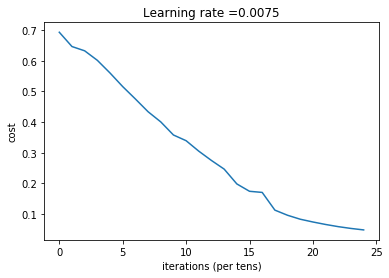

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes =load_data()

# Explore your dataset 
print ("\n\nNumber of training examples: " + str(train_x_orig.shape[0]))
print ("Number of testing examples: " + str(test_x_orig.shape[0]))
print ("Each image is of size: (" + str(train_x_orig.shape[1]) + ", " + str(train_x_orig.shape[2]) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))


# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255


print ("\ntrain_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape),"\n")


n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y),n_iterations=2500, print_cost=True)



In [5]:

def pred(X, y, parameters):
    """
    parameters -- parameters of the trained model
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


predictions_train = pred(train_x, train_y, parameters)
predictions_test = pred(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.72


Cost after iteration 0: 0.6909290674591962


Cost after iteration 100: 0.5622753023024311


Cost after iteration 200: 0.5089048677294836


Cost after iteration 300: 0.4652926491853321


Cost after iteration 400: 0.41952828130371583


Cost after iteration 500: 0.3646023528360772


Cost after iteration 600: 0.316788437050511


Cost after iteration 700: 0.2715984190682293


Cost after iteration 800: 0.2309420031412955


Cost after iteration 900: 0.1820313336905406


Cost after iteration 1000: 0.11738956532691125


Cost after iteration 1100: 0.598177453786497


Cost after iteration 1200: 0.18378094691210142


Cost after iteration 1300: 0.034396333327587174


Cost after iteration 1400: 0.023658323877868453


Cost after iteration 1500: 0.01725201617033765


Cost after iteration 1600: 0.013486870396090702


Cost after iteration 1700: 0.010970045566065777


Cost after iteration 1800: 0.009162232533677645


Cost after iteration 1900: 0.007812945065409603


Cost after iteration 2000: 0.006768845927260708


Cost after iteration 2100: 0.005947125200607316


Cost after iteration 2200: 0.005287831420423062


Cost after iteration 2300: 0.004738582962172335


Cost after iteration 2400: 0.0042803442057239086


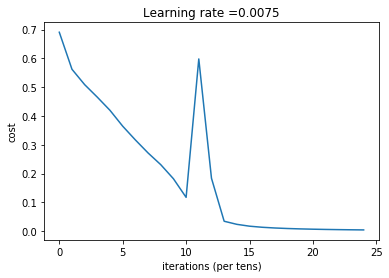

In [6]:
# GRADED FUNCTION: L_layer_model  多层神经网络
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, 
                  n_iterations = 3000, print_cost=False,isPlot=True):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR ->RELU]*(L-1)  ->LINEAR ->SIGMOID.
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector   0/1
    layers_dims -- (n_y,n_h,···,n_h,n_y)
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, n_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL , caches = L_model_forward(X,parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        gradients = L_model_backward(AL,Y,caches)
        
        # Update parameter
        parameters = update_parameters(parameters,gradients,learning_rate)
                
        # Print the cost every 100 training example 
        if  i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
       
    # plot the cost
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
            
    return parameters

#L_layer_model  
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, n_iterations = 2500, print_cost = True)

In [7]:
pred_train = pred(train_x, train_y, parameters) 
pred_test = pred(test_x, test_y, parameters) 

Accuracy: 0.9999999999999998
Accuracy: 0.76


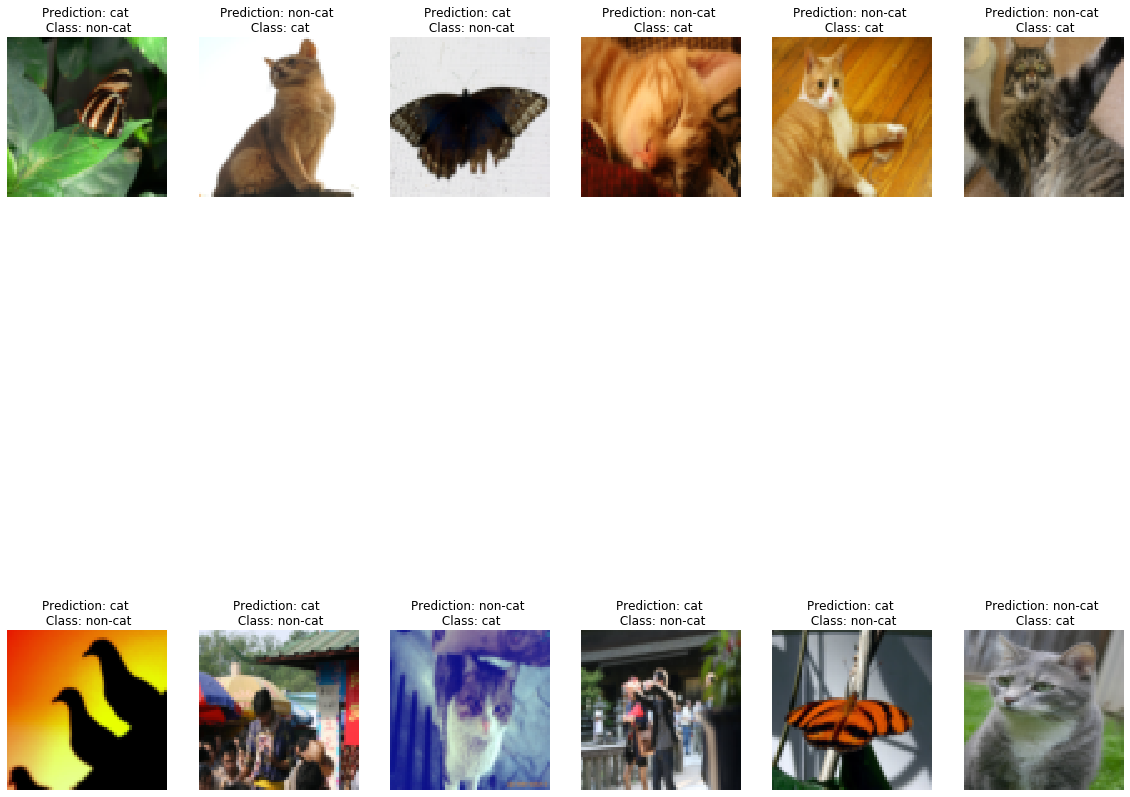

In [8]:

def print_mislabeled_image(classes, X, y, p):
    a = p + y
    mislabeled_indices =np.where(a == 1) #表示预测错误
    # print(mislabeled_indices)  
    #cout  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
    #         array([ 5,  6, 13, 18, 19, 28, 29, 34, 41, 44, 45, 46]))
    mislabeled_indices=mislabeled_indices[1]  #[ 5  6 13 18 19 28 29 34 41 44 45 46] 
    plt.rcParams['figure.figsize'] = (20.0, 20.0)  # set default size of plots
    num_images = len(mislabeled_indices)
    for i in range(len(mislabeled_indices)):
        index = mislabeled_indices[i]
        plt.subplot(2, num_images/2, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3))
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_image(classes, test_x, test_y, pred_test)